In [1]:
import matplotlib.pyplot as plt
import numpy as np
import diagnostics as diag
import numpy.ma as ma
import tracemalloc

In [2]:
#exp = diag.plume('../../data/Nyles/forced_plume_32z/', 'forced_plume_32z')
exp = diag.plume('../../data/Nyles/plume_2days_pressure_4/', 'plume_2days_pressure_4')

In [3]:
#1 subdomain
#%time Ek_lento = exp.KE_volume(0.3, 0.55)
#%time Ea_lento = exp.APE_volume(0.3, 0.55)

In [4]:
%time Ek_rapido = exp.Volume_integral('KE', 0.3, 0.55)

CPU times: user 1.97 s, sys: 1.9 s, total: 3.86 s
Wall time: 4.73 s


In [5]:
%time Ea = exp.Volume_integral('APE', 0.3, 0.55)

CPU times: user 637 ms, sys: 282 ms, total: 919 ms
Wall time: 964 ms


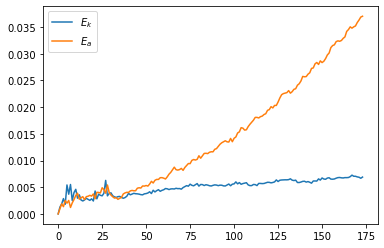

In [6]:
#plt.plot(Ek_lento, label='$E_k$ lento')
plt.plot(Ek_rapido, label='$E_k$')
plt.plot(Ea, label='$E_a$')
#plt.plot(Ea_lento, label='$E_a$ lento')
plt.legend()

In [7]:
exp.Volume_integral('none', 0.3, 0.55)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])

In [7]:
exp.params['global_shape']

(174, 32, 64, 64)

In [18]:
A = exp.Surface_flux('none', 0.3, 0.2)
B = exp.Lateral_flux('none', 0.3, 0.2)

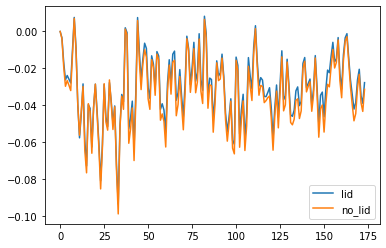

In [20]:
plt.plot(A, label='lid')
plt.plot(B, label='no_lid')
plt.legend()

In [10]:
exp.Flux_levels('mass', 0.3)

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.04820026,  0.15600449,  0.27162336, ...,  0.07315206,
         0.05487912,  0.02279534],
       [ 0.2726546 ,  0.8259635 ,  1.36415734, ...,  0.10369736,
         0.07485665,  0.03071188],
       ...,
       [ 0.05492662,  0.33292261,  1.24502187, ...,  2.14626807,
         0.50577184, -0.36606704],
       [ 0.05147168,  0.46466533,  1.69285847, ...,  3.49788089,
         1.54554945,  0.01659527],
       [-0.41009521, -0.84765897, -0.17479905, ...,  1.84079979,
         0.57381204, -0.30966839]])

In [8]:
exp.Lateral_flux('none', 0.3, 0.55)

array([ 0.00000000e+00, -4.00691184e-03, -1.45594993e-02,  1.95897123e-05,
        2.85715540e-02,  1.78137396e-02,  8.29037609e-03,  3.29283021e-02,
        2.29386027e-02, -1.74821656e-02, -6.86162376e-03, -1.20757204e-02,
       -3.14871158e-02,  1.01447496e-02,  1.46747922e-02, -5.35923766e-02,
       -3.05128630e-02,  3.10629891e-02, -6.63064875e-03, -1.53090803e-02,
        3.13969620e-02,  1.87609875e-02,  4.05804299e-03,  1.60889777e-02,
        1.26238541e-02,  1.70921551e-02,  1.98749242e-03, -2.97697394e-02,
       -1.02703292e-02, -3.65832305e-03, -4.40657245e-02,  9.09497462e-04,
        3.97917308e-02, -1.56078640e-02, -6.02597101e-03,  2.53244380e-02,
       -1.53721828e-02,  9.47093331e-03,  2.30158344e-02, -4.15493508e-02,
        6.73551746e-03,  5.04149933e-02, -2.27312460e-02, -8.75797042e-03,
        2.76832592e-02, -4.05833862e-02, -4.22012915e-02,  7.31138171e-03,
       -1.15442893e-02,  6.21339113e-03,  2.83378357e-02,  1.52461806e-02,
        2.69999759e-02,  

In [32]:
ϕ_b2 = exp.Phi_z(0.3)

In [33]:
E_b_flux = exp.potential_energy_flux(0.3, 0.55)

NameError: name 'Ek' is not defined

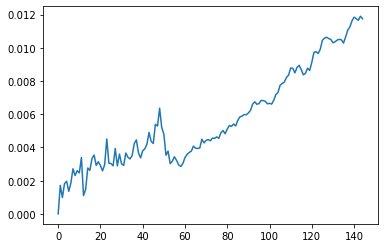

In [34]:
#plt.plot(ϕ_b2, label='$\phi_{b2}$')
plt.plot(Ea, label='$E_a$')
plt.plot(Ek, label='$E_k$')
#plt.axhline(0,c='k',ls='--')
#plt.plot(E_b_flux, label='$E_b$ flux')
plt.legend(fontsize=12)

In [38]:
exp.time.shape[0]

145

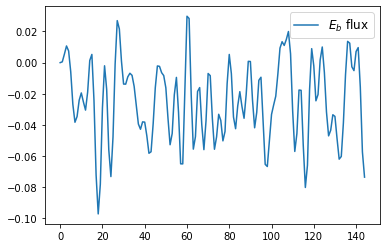

In [13]:
plt.plot(E_b_flux, label='$E_b$ flux')
plt.legend(fontsize=12)

In [8]:
fields = exp.read_vars(['x','y', 'z'])
z = 
XX, YY = np.meshgrid(fields['x']/exp.params['Lx'] - 0.5,
                    fields['y']/exp.params['Ly'] - 0.5)
r = np.sqrt(XX**2 + YY**2)
r0 = 0.01 # <= radius of the heat source (ratio with respect to the  horizontal domain)

msk = 0.5*(1.-np.tanh(r/r0))
delta = 1/(exp.params["global_nz"])
#Q = 1e-5*msk/delta #
Q =1e-5*np.exp(-z/delta)/delta *msk

NameError: name 'z' is not defined

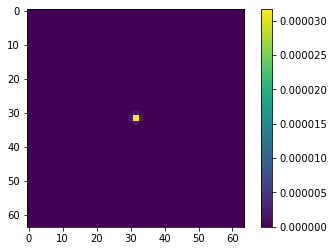

In [21]:
plt.imshow(1e-5*msk/delta)
plt.colorbar()

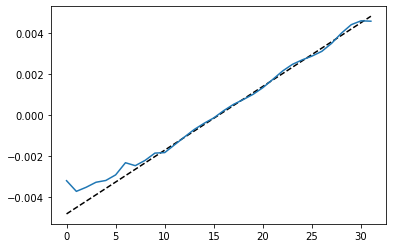

In [5]:
b = exp.read_vars('b')['b']
z = exp.read_vars('z')['z']
br = b[0,:,0,0]
NN = -(np.diff(br)/np.diff(z))[0]
plt.plot(br, '--k')
plt.plot(b[100,:,32,32])

In [39]:
ape = 


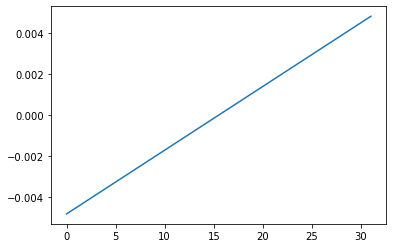

In [29]:
plt.plot(br)